### 개선방향
- `04_02_FE_shop_cats.ipynb`에서 전처리를 완료한 데이터를 사용하여 LightGBM을 학습

# Module

In [10]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

# Data

In [2]:
data_path = "./data/"

all_data = joblib.load(data_path + 'all_data2.joblib')
sub = pd.read_csv(data_path + 'sample_submission.csv')

# Model

## prepare

In [ ]:
x_train = all_data[all_data['date_block_num'] < 33]
x_train = x_train.drop(['item_cnt_month'], axis=1)

x_val = all_data[all_data['date_block_num'] == 33]
x_val = x_val.drop(['item_cnt_month'], axis=1)

x_test = all_data[all_data['date_block_num'] == 34]
x_test = x_test.drop(['item_cnt_month'], axis=1)

y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
y_val = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

x_all = pd.concat([x_train, x_val])
y_all = pd.concat([y_train, y_val])

del all_data

In [ ]:
cat_features = ['shop_id', 'type', 'subtype', 'shop_type', 'shop_category', 'item_category_id', 'city', 'month']

dtrain = lgb.Dataset(x_train, y_train, categorical_feature=cat_features)
dval = lgb.Dataset(x_val, y_val, categorical_feature=cat_features, reference=dtrain)

## optuna
- 과적합을 줄이기 위해 `max_depth`, `min_child_samples`, `reg_alpha`, `reg_lambda`를 추가

In [ ]:
%%time

fixed_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'force_col_wise': True,
    'random_state': 2025,
    'verbosity': -1
}

def objective_lgbm(trial):
    params = {
        **fixed_params,
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
    }
    
    pruning_callback = LightGBMPruningCallback(trial, 'rmse', valid_name='eval')
    
    lgb_model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=1500,
        valid_sets=[dval],
        valid_names=['eval'],
        callbacks=[
            early_stopping(stopping_rounds=300, verbose=False),
            log_evaluation(period=0),
            pruning_callback
        ]
    )
    
    trial.set_user_attr("best_iter", lgb_model.best_iteration)
    
    preds = lgb_model.predict(x_val, num_iteration=lgb_model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse 


sampler = TPESampler(seed=2025)
study_lgbm = optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=10)

[I 2025-12-03 00:53:37,783] A new study created in memory with name: no-name-b57749c9-a975-4147-94e6-77c9b1ba2672
[I 2025-12-03 00:57:33,167] Trial 0 finished with value: 0.7850739072715913 and parameters: {'num_leaves': 154, 'learning_rate': 0.059662768998574464, 'feature_fraction': 0.9663028199432513, 'bagging_fraction': 0.7227840820237976, 'bagging_freq': 4}. Best is trial 0 with value: 0.7850739072715913.
[I 2025-12-03 01:13:37,823] Trial 1 finished with value: 0.7813212948353228 and parameters: {'num_leaves': 203, 'learning_rate': 0.020641210885923914, 'feature_fraction': 0.7463084687531312, 'bagging_fraction': 0.9821192096250286, 'bagging_freq': 9}. Best is trial 1 with value: 0.7813212948353228.
[I 2025-12-03 01:19:52,429] Trial 2 finished with value: 0.7852842351252991 and parameters: {'num_leaves': 282, 'learning_rate': 0.040005174874880194, 'feature_fraction': 0.5208589864093756, 'bagging_fraction': 0.8847289359689058, 'bagging_freq': 1}. Best is trial 1 with value: 0.7813212

CPU times: user 2h 45min 15s, sys: 18.2 s, total: 2h 45min 33s
Wall time: 44min 57s


In [12]:
print(f'Total Trials : {len(study_lgbm.trials)}')
print(f'Best Trial : {study_lgbm.best_trial.number}')
print(f'Best Iteration : {study_lgbm.best_trial.user_attrs['best_iter']}')
print(f'Best Score : {study_lgbm.best_value:.5f}')
print('=='*20,'Best Parameters', '=='*20)
for key, value in study_lgbm.best_params.items():
    print(f'{key} : {value}')

Total Trials : 10
Best Trial : 6
Best Iteration : 156
Best Score : 0.78103
======================================== Best Parameters ========================================
num_leaves : 230
learning_rate : 0.09589520181770768
feature_fraction : 0.7565706439029963
bagging_fraction : 0.9382478206260831
bagging_freq : 1


- LR이 0.095로 비교적 높아 LR을 줄이고 iteration을 늘리는 방향으로 본모델 학습

/tmp/ipykernel_9663/1748665859.py:1: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_lgbm)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

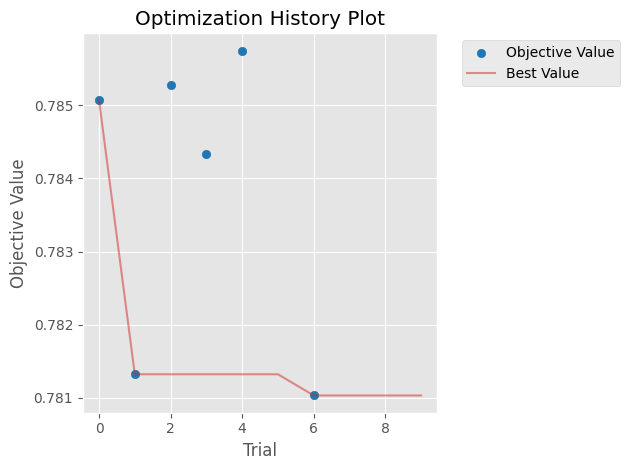

In [13]:
plot_optimization_history(study_lgbm)

/tmp/ipykernel_9663/3004270277.py:1: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_lgbm)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

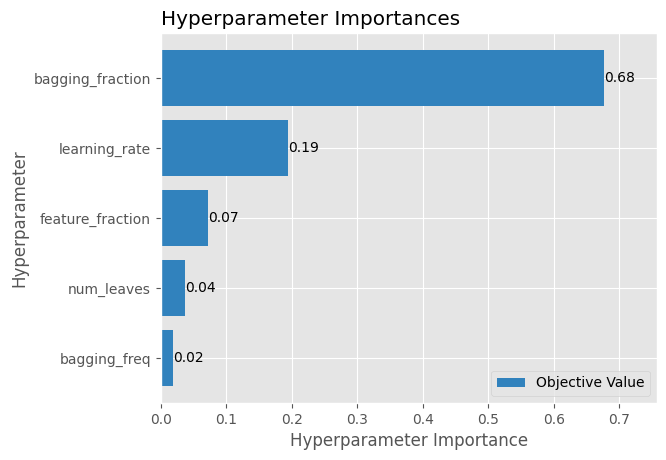

In [14]:
plot_param_importances(study_lgbm)

## train

In [16]:
best_params = study_lgbm.best_params
best_params.update(fixed_params)
best_iter = study_lgbm.best_trial.user_attrs['best_iter']
best_params['learning_rate'] = best_params['learning_rate'] / 2

In [17]:
dtrain_all = lgb.Dataset(x_all, y_all, categorical_feature=cat_features)
final_iter = int(best_iter * 1.1 * 2)

In [18]:
%%time

final_lgbm_model = lgb.train(
    params=best_params,
    train_set=dtrain_all,
    num_boost_round=final_iter,
    valid_sets=[dtrain_all],
    callbacks=[
        log_evaluation(period=100)
    ]
)

[100]	training's rmse: 0.803986
[200]	training's rmse: 0.772187
[300]	training's rmse: 0.754433
CPU times: user 10min 31s, sys: 2.27 s, total: 10min 33s
Wall time: 2min 51s


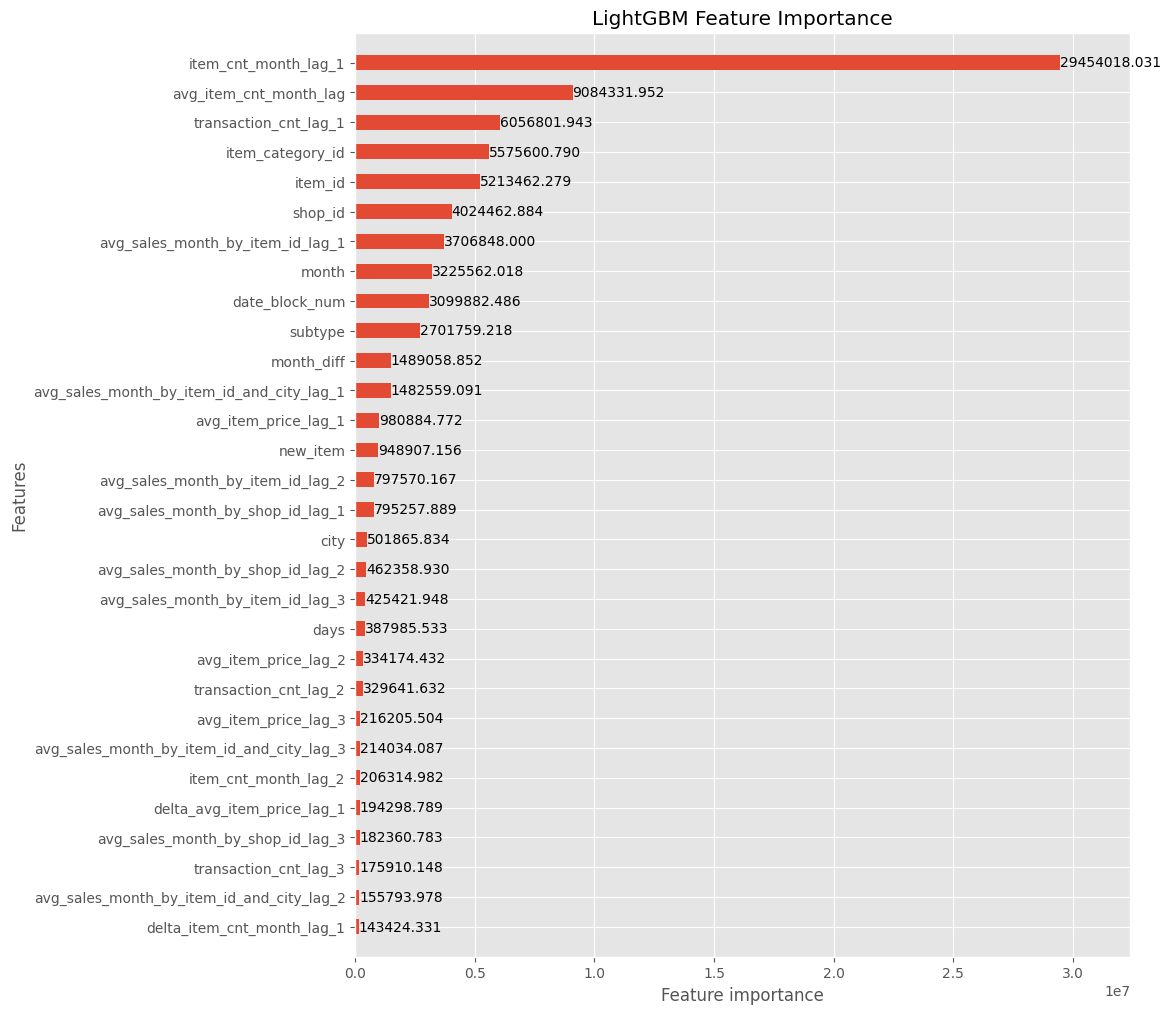

In [19]:
plt.figure(figsize=(10, 12)) 
lgb.plot_importance(final_lgbm_model, max_num_features=30, height=0.5, ax=plt.gca(), importance_type='gain')
plt.title('LightGBM Feature Importance')
plt.show()

In [20]:
final_lgbm_model.save_model(data_path + '05_lgbm_model_shop_cats.txt')

## prediction

In [21]:
predictions = final_lgbm_model.predict(x_test, num_iteration=final_lgbm_model.best_iteration).clip(0, 20)
sub['item_cnt_month'] = predictions
sub.head()

,ID,item_cnt_month
0,0,0.437915
1,1,0.408592
2,2,0.640040
3,3,0.361526
4,4,2.654178


In [22]:
sub.to_csv(data_path + '05_submission_lgbm_shop_cats.csv', index=False)

In [23]:
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f "./data/05_submission_lgbm_shop_cats.csv" -m "05_submission_lgbm_shop_cats"

100%|██████████████████████████████████████| 5.21M/5.21M [00:00<00:00, 10.6MB/s]
Successfully submitted to Predict Future Sales

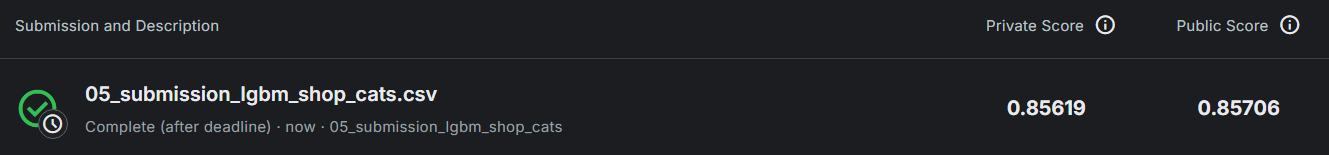
- private score 기준 0.85988에서 0.85619로 상승하였으나 여전히 학습단계에서의 rmse값과 차이가 커 과적합이 있는 것으로 판단됨